## Assignment 4 - Affine

#### Sung-Jun (Tony) Baek. CSE5280

In [1]:
from turtle import width
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Set, Dict, Tuple, Optional
import numpy as np
import imageio
from scipy.spatial import Delaunay
from PIL import Image

### Affine Triangle

The objective of this assignment is to warp(affine) image based on given affine values(e.g. affine matrix).

#### Affining triangle example
Affine the shpae of the triangles.
If the initial input points are given like below,

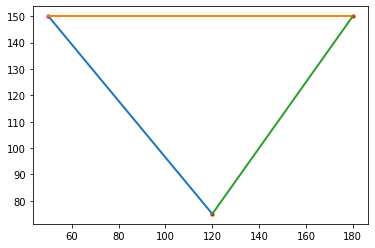

In [2]:
triangle_points = np.array([[120,75], [50,150], [180,150]])
triangle_edges = np.array([[0,1], [1,2], [2,0]])

def draw_triagnle(points, edges, image):
    if not (image is None):
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        ax.set_title('Image warp')
        ax.invert_yaxis()
        ax.imshow(image)
    for edge in edges:
        start = edge[0]
        end = edge[1]
        x, y = points[start]
        x2, y2 = points[end]
        plt.plot((x, x2), (y, y2), linewidth=2)
    plt.scatter(points[:,0], points[:,1], marker='o', s=10 ,c="Red")
    plt.show()
    plt.gcf().clear()
    plt.clf()
    plt.cla()
    plt.close()
    
draw_triagnle(triangle_points, triangle_edges, None)

#### Changing triangle coordination into matrix

In order to apply affine to triangle coordination, conversion is required.

Also, let affine be randomly predefined value sets in matrix 6 x 1 form that is a mixture of  

1. identity
2. tranlation
3. reflection
4. scale
5. rotate
6. shear

In [3]:
#Takes 3 list of triangle coordination
def form_single_triangle_matrix(tri_coord):
    x1 = tri_coord[0][0]
    y1 = tri_coord[0][1]
    x2 = tri_coord[1][0]
    y2 = tri_coord[1][1]
    x3 = tri_coord[2][0]
    y3 = tri_coord[2][1]
    
    entire_matrix = [[x1, y1, 1, 0, 0, 0],
                     [0, 0, 0, x1, y1, 1],
                     [x2, y2, 1, 0, 0, 0],
                     [0, 0, 0, x2, y2, 1],
                     [x3, y3, 1, 0, 0, 0],
                     [0, 0, 0, x3, y3, 1]]
    return np.array(entire_matrix)

print(triangle_points)
tri_matrix_1 = form_single_triangle_matrix(triangle_points)

#a11, a12, a13, a21, a22, a23
affine_matrix = np.array([1, 3, 1, 2, 1, 1]) #transposed 1d is identical to original 1d

print("Original triangle matrix: \n" + str(tri_matrix_1))
print("Affine matrix: \n" + str(affine_matrix))


[[120  75]
 [ 50 150]
 [180 150]]
Original triangle matrix: 
[[120  75   1   0   0   0]
 [  0   0   0 120  75   1]
 [ 50 150   1   0   0   0]
 [  0   0   0  50 150   1]
 [180 150   1   0   0   0]
 [  0   0   0 180 150   1]]
Affine matrix: 
[1 3 1 2 1 1]


#### Applying affine matrix to triangle matrix

As image result shown below, the image has to be flipped upside down with scewed image scale.


Affined triangle matrix (x1, y1, x2, y2, x3, y3): 
[346 316 501 251 631 511]


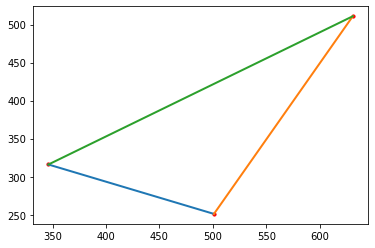

In [4]:
def apply_affine_matrix(matrix, affine_matrix):
    return np.matmul(matrix, affine_matrix)

tri_matrix_2 = apply_affine_matrix(tri_matrix_1, affine_matrix)

print("Affined triangle matrix (x1, y1, x2, y2, x3, y3): \n" + str(tri_matrix_2))

def form_coordination_from_matrix(tri_matrix):
    return np.array([[tri_matrix[0],tri_matrix[1]],
                     [tri_matrix[2],tri_matrix[3]],
                     [tri_matrix[4],tri_matrix[5]]
                    ])
triangle_points = form_coordination_from_matrix(tri_matrix_2)
draw_triagnle(triangle_points, triangle_edges, None)

### Affine Image with Triangle

  Reform image into other form
  
  Note that image coordination has inverted y-axis. Trianlge with image population will result a triagnle to be reflected on y-axis

#### Read image data
  If given data looks like below.
  function image_import will return width, height in pixel size and RGB data list of each pixel

![Example Image](./data/input/example1.png)

In [5]:
def image_import(file):
    image = Image.open(file, 'r')
    width, height = image.size            # width, height in pixel
    pix_data_list = list(image.getdata()) # single list of rgb data
    return width, height, pix_data_list, image

In [6]:
width, height, pxl_data, image = image_import("./data/input/example1.png")

#### Make trianglualtion on image

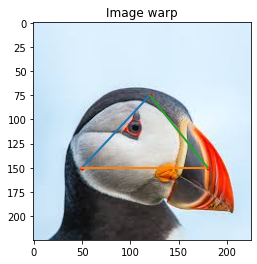

In [7]:
#Triangle points
triangle_points = np.array([[120,75], [50,150], [180,150]])
triangle_edges = np.array([[0,1], [1,2], [2,0]])
draw_triagnle(triangle_points, triangle_edges, image)

#### Make pixel matrix - in 2d list (not array)
  make matrix with given list of pixel data, width and height

In [8]:
def form_matrix(width, height, pxl_data):
    #make a single row
    matrix = []
    index = 0
    for y in range(height):
        row = []
        for x in range(width):
            row.append(pxl_data[index])
            index += 1
        matrix.append(row)
    return matrix

In [9]:
img_matrix = form_matrix(width, height, pxl_data)

#### Affine warp image with triangle
  
  First, we apply affine value to every points. Then, we do triangle affine as well.
  
  > Note that affined coordination may have different width and heigh boundary.
  
  > Given triangle points: np.array([[120,75], [50,150], [180,150]])

In [10]:
#Triangle points
triangle_points = np.array([[120,75], [50,150], [180,150]])
triangle_edges = np.array([[0,1], [1,2], [2,0]])

#a11, a12, a13, a21, a22, a23
affine_matrix = np.array([1, 3, 1, 2, 1, 1]) #transposed 1d is identical to original 1d

#Inverse for 1 by 3 matrix
inverse_affine_matrix= np.linalg.inv(np.array([[1, 3, 1], [2, 1, 1], [0, 0, 1]]))

In [11]:
#Inverse for points
def affine_single_pixel(points):
    x = points[0]
    y = points[1]
    points_matrix = np.array([[x, y, 1, 0, 0, 0],
                              [0, 0, 0, x, y, 1]])
    return np.matmul(points_matrix, affine_matrix)

In [12]:
#Takes affined location to find original location to map cooresponding color
def inverse_point_and_get_data(affined_points, x_min, x_max, y_min, y_max):
    x = affined_points[0]
    y = affined_points[1]
    extended_points = np.array([x, y, 1])
    #Only takes x and y value.
    inversed_points = (np.matmul(inverse_affine_matrix, extended_points)[:2])
    return inversed_points


In [13]:
#Needs this to aquire maximum boundary
def calculate_warped_size(width, height):
    x_min = None
    x_max = None
    y_min = None
    y_max = None
    for y in range(height):
        for x in range(width):
            points = affine_single_pixel([x, y])
            p_x = points[0]
            p_y = points[1]
            if (x_min == None):
                x_min = p_x
            if (x_max == None):
                x_max = p_x
            if (y_min == None):
                y_min = p_y
            if (y_max == None):
                y_max = p_y
                
            if (p_x > x_max):
                x_max = p_x
            if (p_x < x_min):
                x_min = p_x
            if (p_y > y_max):
                y_max = p_y
            if (p_y < y_min):
                y_min = p_y
    return x_min, x_max, y_min, y_max

In [14]:
def affineWarp(img_matrix, width, height, triangle_points):    
    #Get affine size data
    x_min, x_max, y_min, y_max = calculate_warped_size(width, height)
    print("x-min/max | y-min/max: ", x_min, x_max, y_min, y_max)
    
    #Initialize data
    affined_img = []
    for y in range(y_min, y_max + 1):
        row = []
        for x in range(x_min, x_max + 1):
            row.append(np.array([0,0,0]))
        affined_img.append(row)

    #Assign affined coordinates
    for y in range(y_min, y_max):
        for x in range(x_min, x_max):
            original_points = inverse_point_and_get_data([x,y], x_min, x_max, y_min, y_max)
            origin_x = original_points[0]
            origin_y = original_points[1]
            #If points are in the width, height range, color pixel. If not, -> black
            if ((origin_x < width and origin_x >= 0)\
                and (origin_y < height and origin_y >= 0)):
                affined_img[y][x] = img_matrix[int(origin_y)][int(origin_x)]

    #Affine triangle
    tri_matrix = form_single_triangle_matrix(triangle_points)
    tri_matrix_2 = apply_affine_matrix(tri_matrix, affine_matrix)
    affine_triangle_points = form_coordination_from_matrix(tri_matrix_2)
    
    return affined_img, affine_triangle_points

#### Final result of affine image

Note that y-axis is reversed.


x-min/max | y-min/max:  1 897 1 673


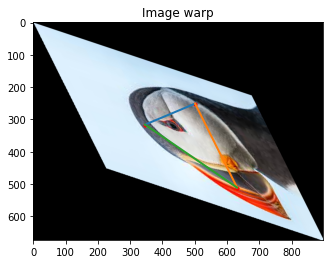

In [15]:
affined_img, new_triangle_points = affineWarp(img_matrix, width, height, triangle_points)
draw_triagnle(new_triangle_points, triangle_edges, affined_img)